# Chapter 3

This notebook contains the commands that are shown in the lecture 3.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb

## Grouping data by a common variable

### Description of data - Triton cluster file statistics


[read_table](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.read_table.html)

[Timedelta](https://pandas.pydata.org/pandas-docs/stable/user_guide/timedeltas.html)

In [2]:
def load_filesizes(filesizes_file):
    filesizes = pd.read_table(filesizes_file, sep='\s+', names=['Bytes','MonthsTo2021', 'Files'])
    
    # Remove empty files
    filesizes = filesizes[filesizes.loc[:,'Bytes'] != 0]
    # Create a column for log2 of bytes
    filesizes['BytesLog2'] = np.log2(filesizes.loc[:, 'Bytes'])
    filesizes.loc[:,'BytesLog2'] = filesizes.loc[:,'BytesLog2'].astype(np.int64)
    # Determine total space S used by N files of size X during date D: S=N*X 
    filesizes['SpaceUsage'] = filesizes.loc[:,'Bytes']*filesizes.loc[:,'Files']
    # Determine file year and month from the MonthsTo2021-column
    filesizes['TotalMonths'] = 2021*12 - filesizes['MonthsTo2021'] - 1
    filesizes['Year'] = filesizes['TotalMonths'] // 12
    filesizes['Month'] = filesizes['TotalMonths'] % 12 + 1
    filesizes['Day'] = 1
    
    # Set year for really old files and files with incorrect timestamps
    invalid_years = (filesizes['Year'] < 2010) | (filesizes['Year'] > 2020)
    filesizes.loc[invalid_years, ['Year','Month']] = np.NaN
    
    # Get month names for the correct ordering of Month categories
    month_names = pd.date_range(start='2000-01', freq='M', periods=12).month_name()
    # Create Date
    filesizes['Date'] = pd.to_datetime(filesizes[['Year', 'Month', 'Day']])
    # Set Month
    filesizes['Month'] = pd.Categorical(filesizes['Date'].dt.month_name(), categories=month_names, ordered=True)
    # Set Month to be an ordered categorical with predefined levels 
    filesizes['Month'] = pd.Categorical(filesizes['Month'], categories=month_names, ordered=True)
    # Sort data based on Date and BytesLog2
    filesizes.sort_values(['Date','BytesLog2'], inplace=True)
    # Remove old columns
    filesizes.drop(['MonthsTo2021','TotalMonths', 'Day'], axis=1, inplace=True)
    return filesizes

filesizes = load_filesizes('../data/filesizes_timestamps.txt')
filesizes.head()

,Bytes,Files,BytesLog2,SpaceUsage,Year,Month,Date
287,1,5,0,5,2010.0,January,2010-01-01
451,2,3,1,6,2010.0,January,2010-01-01
627,4,27,2,108,2010.0,January,2010-01-01
822,8,136,3,1088,2010.0,January,2010-01-01
1057,16,208,4,3328,2010.0,January,2010-01-01


### Simple groupings and summaries - Calculating new files per year

[resample](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Series.resample.html#pandas.Series.resample)

In [3]:
# Drop rows with NaNs (invalid years)
newfiles_relevant = filesizes.dropna(axis=0)
# Pick relevant columns
newfiles_relevant = newfiles_relevant.loc[:,['Year','Files']]
newfiles_relevant.head()

,Year,Files
287,2010.0,5
451,2010.0,3
627,2010.0,27
822,2010.0,136
1057,2010.0,208


In [4]:
print(newfiles_relevant.shape)

newfiles_yearly_sum = newfiles_relevant.groupby('Year').agg('sum')

print(newfiles_yearly_sum.shape)
newfiles_yearly_sum.head()

(4698, 2)
(11, 1)


,Files
Year,
2010.0,5590287
2011.0,13197038
2012.0,17099900
2013.0,14755151
2014.0,26329321


In [5]:
newfiles_yearly_sum.reset_index(inplace=True)

newfiles_yearly_sum.head()

,Year,Files
0,2010.0,5590287
1,2011.0,13197038
2,2012.0,17099900
3,2013.0,14755151
4,2014.0,26329321


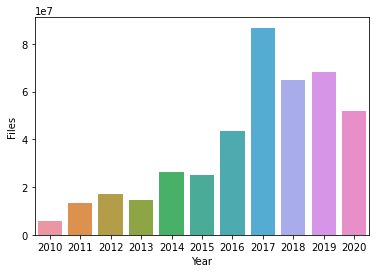

In [6]:
newfiles_yearly_sum['Year'] = newfiles_yearly_sum['Year'].astype(int).astype('category')
sb.barplot(x='Year', y='Files', data=newfiles_yearly_sum, ci=None)
plt.savefig('newfiles_yearly_sum_python.svg')

### Creating a function for many different summaries

In [7]:
def aggregate_filesize_data(data, groupings, targets, agg_function):
    # Drop rows with NaNs (invalid years)
    data_relevant = data.dropna(axis=0)
    # Pick relevant columns
    data_relevant = data_relevant.loc[:, groupings + targets]
    # Change grouping to category for prettier plotting
    data_relevant[groupings] = data_relevant[groupings].astype('category')

    # Aggregate data
    data_aggregated = data_relevant.groupby(groupings).agg(agg_function).reset_index()
    return data_aggregated

newfiles_yearly_sum = aggregate_filesize_data(filesizes, ['Year'], ['Files'], 'sum')
newfiles_yearly_sum.head()

,Year,Files
0,2010.0,5590287
1,2011.0,13197038
2,2012.0,17099900
3,2013.0,14755151
4,2014.0,26329321


   Year     Files      SpaceUsage
0  2010   5590287   2260716407068
1  2011  13197038   7000732111463
2  2012  17099900  15475575370580
3  2013  14755151  15445375302767
4  2014  26329321  42530364324322
      Month     Files      SpaceUsage
0   January  34921070  43131219269056
1  February  35707864  71022501061692
2     March  25494722  56516865081262
3     April  31224476  75382094990077
4       May  37816173  75338621861676


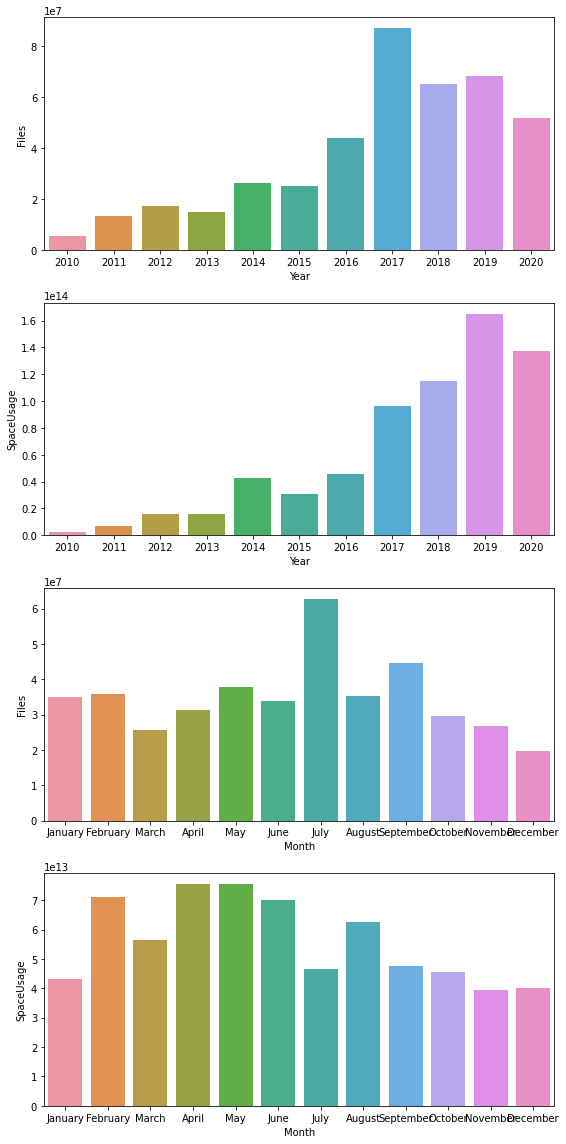

In [8]:
yearly_sum = aggregate_filesize_data(filesizes, ['Year'], ['Files', 'SpaceUsage'], 'sum')
monthly_sum = aggregate_filesize_data(filesizes, ['Month'], ['Files', 'SpaceUsage'], 'sum')

yearly_sum['Year'] = yearly_sum['Year'].astype(int).astype('category')

print(yearly_sum.head())
print(monthly_sum.head())

fig, ((ax1, ax2, ax3, ax4))=plt.subplots(nrows=4, figsize=(8,16))
sb.barplot(x='Year', y='Files', data=yearly_sum, ci=None, ax=ax1)
sb.barplot(x='Year', y='SpaceUsage', data=yearly_sum, ci=None, ax=ax2)
sb.barplot(x='Month', y='Files', data=monthly_sum, ci=None, ax=ax3)
sb.barplot(x='Month', y='SpaceUsage', data=monthly_sum, ci=None, ax=ax4)
plt.tight_layout()
plt.savefig('newall_python.svg')

## Using bootstrapping/resampling methods for the calculation of statistical moments

### Quick overview of bootstrapping

In [9]:
# Drop rows with NaNs (invalid years)
newfiles_relevant2 = filesizes.dropna(axis=0)
# Pick relevant columns
newfiles_relevant2 = newfiles_relevant2.loc[:,['Year','BytesLog2','Files']]
# Aggregate based on Year and BytesLog2
newfiles_yearly_sum2 = newfiles_relevant2.groupby(['Year','BytesLog2']).agg('sum')

newfiles_yearly_sum2.head()

Files
Year   BytesLog2       
2010.0 0            124
       1           1632
       2           5626
       3          26287
       4          65074

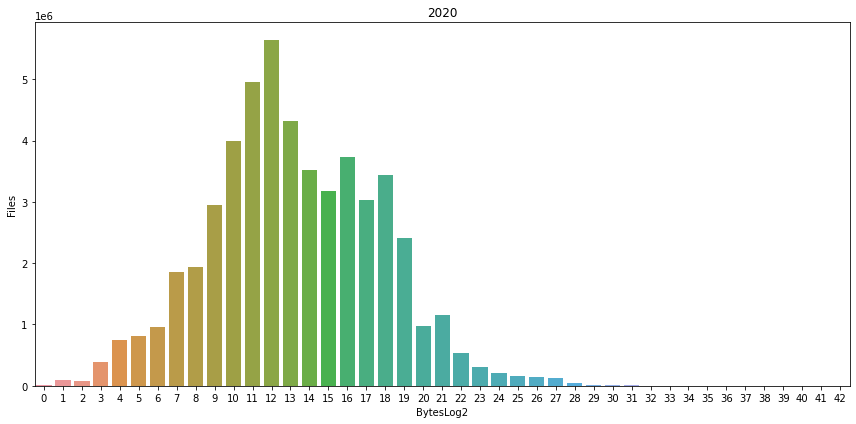

In [10]:
yearly_bytes_sum = aggregate_filesize_data(filesizes, ['Year','BytesLog2'], ['Files', 'SpaceUsage'], 'sum')

bytes_2020 = yearly_bytes_sum[yearly_bytes_sum['Year'] == 2020]

plt.figure(figsize=(12,6))
sb.barplot(x='BytesLog2', y='Files', data=bytes_2020, ci=None)
plt.title(2020)
plt.tight_layout()
plt.savefig('file-distribution-2020_python.svg')

In [11]:
# Pick target data column and convert it to integer
target_data = bytes_2020['BytesLog2'].copy().astype('int')
# Pick weight data column
weight_data = bytes_2020['Files'].copy()

# IMPORTANT:
#    There might be categories in BytesLog2 that do not contain any data.
#    We'll have to fill zeros to those rows of Files.
weight_data.fillna(0, inplace=True)

# Normalize weight_data into probabilities
weight_data = weight_data/weight_data.sum()

print(target_data.head())
print(weight_data.head())

430    0
431    1
432    2
433    3
434    4
Name: BytesLog2, dtype: int64
430    0.000327
431    0.001940
432    0.001471
433    0.007406
434    0.014570
Name: Files, dtype: float64


In [12]:
# Create means vector
means = np.zeros(10, dtype=np.float64)
for i in range(10):
    # Calculate resampled mean
    means[i] = np.mean(np.random.choice(target_data, 100, replace=True, p=weight_data))
means = pd.Series({'SampledMeans': means})
print(means.head())
print('Estimated sample mean:', means['SampledMeans'].mean())

SampledMeans    [13.38, 12.25, 12.75, 13.35, 12.72, 13.18, 13....
dtype: object
Estimated sample mean: 13.089000000000002


In [13]:
def get_bootstrapped_means(dataset, target_col, weight_col, n_means=1000):
    # Pick relevant columns
    df = dataset[[target_col, weight_col]].copy()
    # Pick target data column
    target_data = df[target_col]
    # Pick weight data column
    weight_data = df[weight_col]
    # Fill zeros to those byte sizes that are not present in the Files-data
    weight_data.fillna(0, inplace=True)
    # Normalize weight_data into probabilities
    weight_data = weight_data/weight_data.sum()
    
    # Create means vector
    means = np.zeros(n_means, dtype=np.float64)
    for i in range(n_means):
        # Calculate resampled mean
        means[i] = np.mean(np.random.choice(target_data, 100, replace=True, p=weight_data))

    # Store results as a DataFrame
    means = pd.Series({'SampledMeans': means})

    return means

bootstrapped_means = get_bootstrapped_means(bytes_2020, 'BytesLog2', 'Files', n_means=1000)
print(bootstrapped_means.head())
print('Estimated sample mean:', bootstrapped_means['SampledMeans'].mean())

SampledMeans    [12.94, 13.12, 12.97, 12.79, 13.38, 12.85, 12....
dtype: object
Estimated sample mean: 13.21457


### Using nested dataframes to help with bootstrapping

In [14]:
bootstrapped_means = yearly_bytes_sum.groupby('Year').apply(lambda x: get_bootstrapped_means(x, 'BytesLog2', 'Files', n_means=5))
bootstrapped_means.head()

,SampledMeans
Year,
2010.0,"[13.11, 12.89, 13.61, 12.83, 12.73]"
2011.0,"[14.08, 13.94, 13.6, 13.84, 13.85]"
2012.0,"[11.41, 10.56, 10.36, 10.9, 10.55]"
2013.0,"[13.99, 13.34, 13.29, 13.82, 13.98]"
2014.0,"[14.41, 13.39, 13.94, 14.15, 13.98]"


In [15]:
bootstrapped_means['Mean'] = bootstrapped_means['SampledMeans'].apply(np.mean)
bootstrapped_means.head()

,SampledMeans,Mean
Year,,
2010.0,"[13.11, 12.89, 13.61, 12.83, 12.73]",13.034
2011.0,"[14.08, 13.94, 13.6, 13.84, 13.85]",13.862
2012.0,"[11.41, 10.56, 10.36, 10.9, 10.55]",10.756
2013.0,"[13.99, 13.34, 13.29, 13.82, 13.98]",13.684
2014.0,"[14.41, 13.39, 13.94, 14.15, 13.98]",13.974


In [16]:
def bootstrap_byteslog2_mean(dataset, group_variable, target_variable, n_means=1000):

    bootstrapping_function = lambda x: get_bootstrapped_means(x, 'BytesLog2', target_variable, n_means=n_means)

    bootstrapped_means = dataset.groupby(group_variable).apply(bootstrapping_function)
    bootstrapped_means['Mean'] = bootstrapped_means['SampledMeans'].apply(np.mean)
    return bootstrapped_means

bootstrapped_yearly_means = bootstrap_byteslog2_mean(yearly_bytes_sum, 'Year', 'Files', n_means=1000)
bootstrapped_yearly_means.head()

,SampledMeans,Mean
Year,,
2010.0,"[13.03, 13.48, 12.51, 13.5, 13.01, 13.23, 13.6...",12.96021
2011.0,"[14.34, 13.54, 13.78, 14.03, 13.5, 14.2, 13.81...",14.04411
2012.0,"[11.13, 10.85, 10.14, 10.27, 10.94, 11.19, 10....",10.67477
2013.0,"[12.58, 13.42, 13.24, 13.78, 13.39, 13.41, 13....",13.40986
2014.0,"[14.06, 14.04, 13.9, 13.69, 14.41, 14.09, 13.9...",14.04092


In [17]:
bootstrapped_yearly_means_distribution = bootstrapped_yearly_means.drop('Mean', axis=1).explode('SampledMeans').reset_index()

bootstrapped_yearly_means_distribution.head()

,Year,SampledMeans
0,2010.0,13.03
1,2010.0,13.48
2,2010.0,12.51
3,2010.0,13.5
4,2010.0,13.01


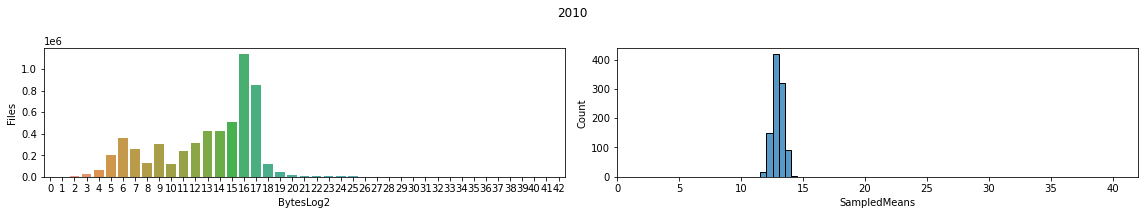

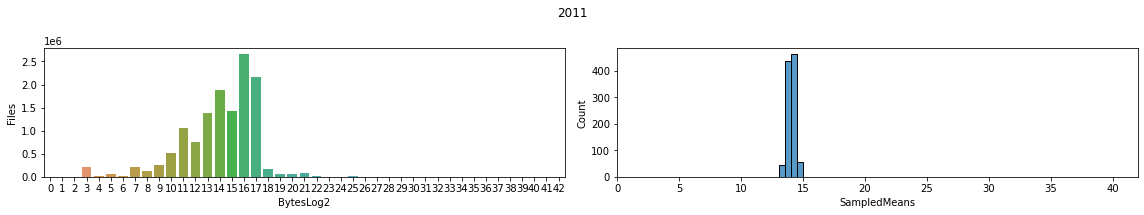

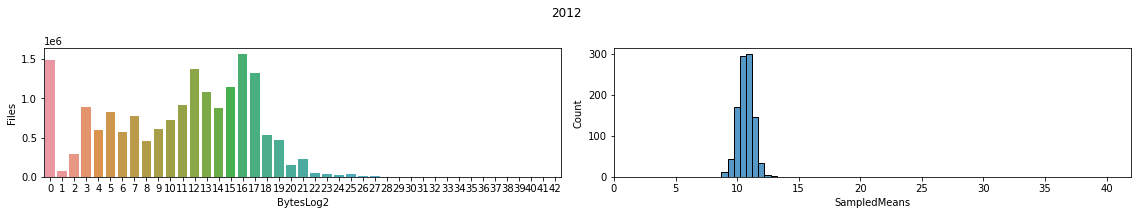

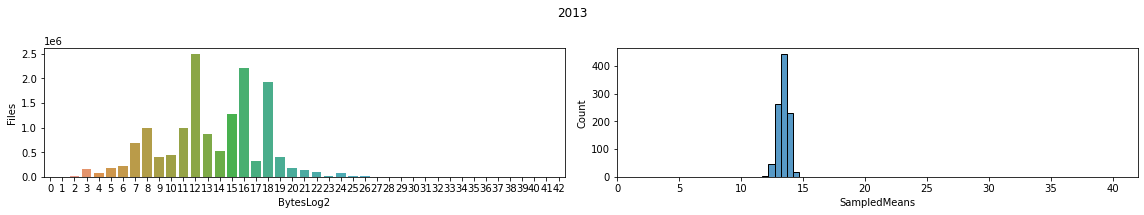

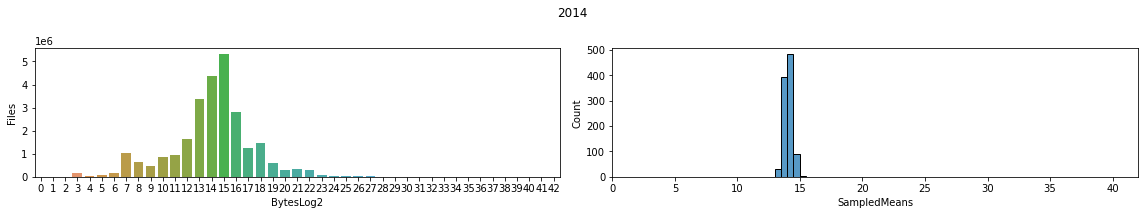

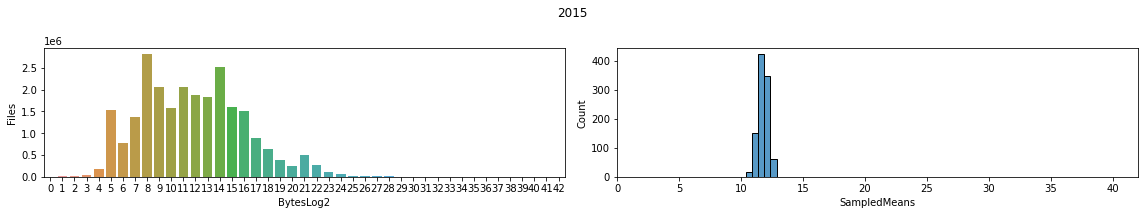

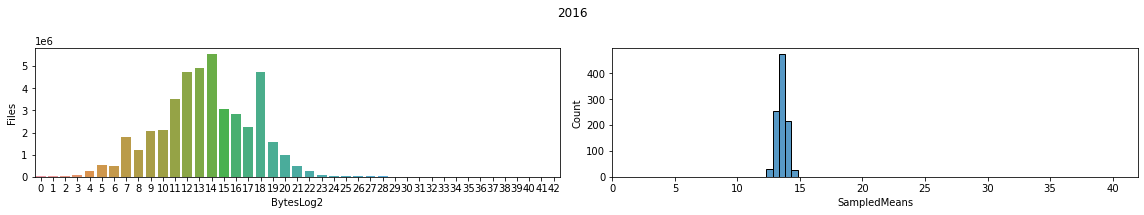

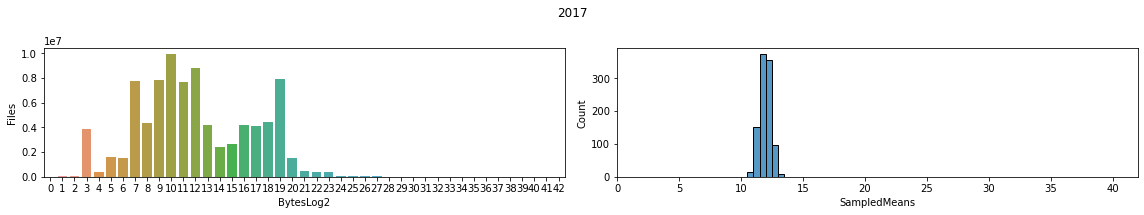

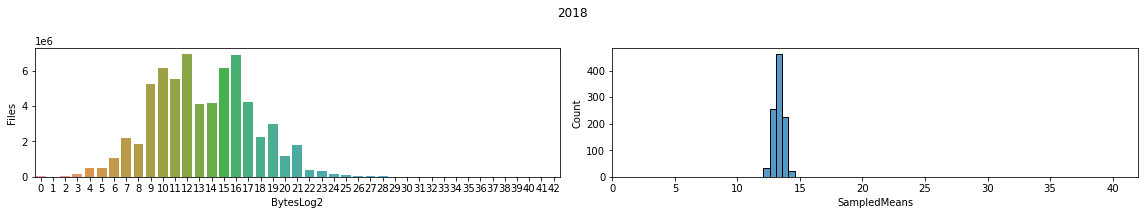

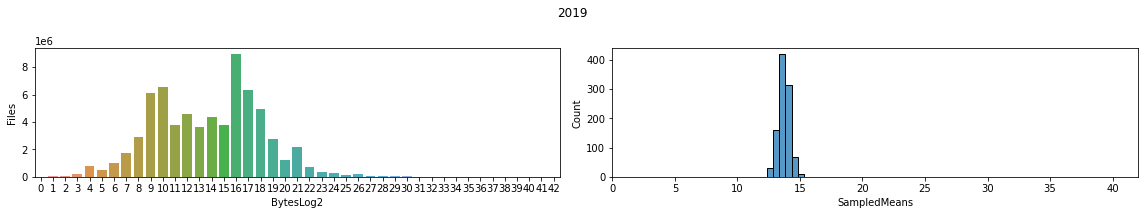

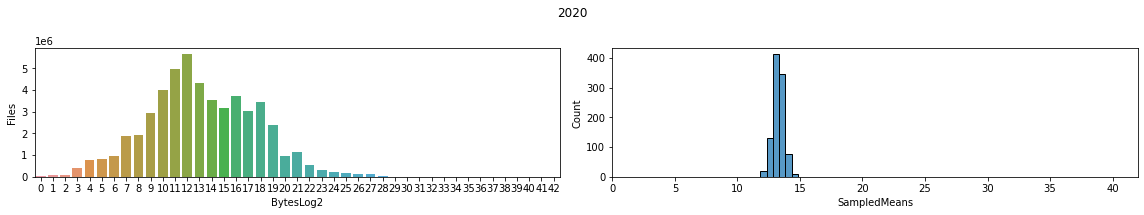

In [18]:
for (year, real_data), (year_sampled, bootstrapped_data) in zip(yearly_bytes_sum.groupby('Year'), bootstrapped_yearly_means_distribution.groupby('Year')):
    figure, (ax1, ax2) = plt.subplots(1,2,figsize=(16,3))
    figure.suptitle(int(year))
    sb.barplot(x='BytesLog2', y='Files', data=real_data, ci=None, ax=ax1)
    sb.histplot(x='SampledMeans', binwidth=0.5, data=bootstrapped_data, ax=ax2)
    plt.xlim(left=min(yearly_bytes_sum['BytesLog2']), right=max(yearly_bytes_sum['BytesLog2']))
    plt.tight_layout()
    plt.savefig('file-distributions-%d_python.svg' % year)

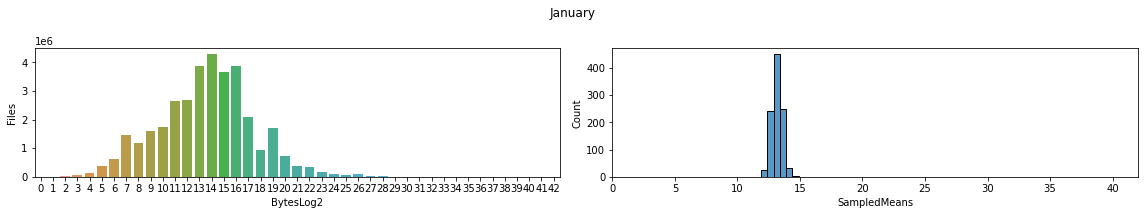

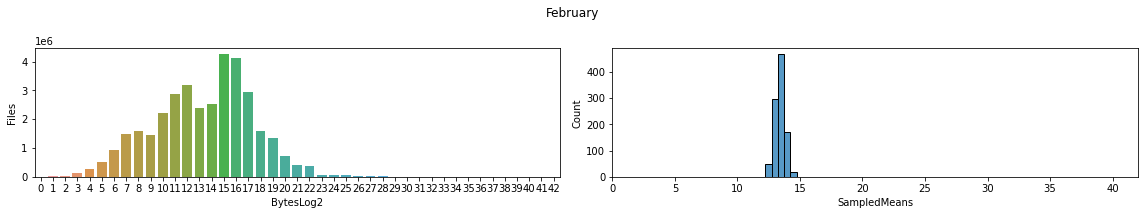

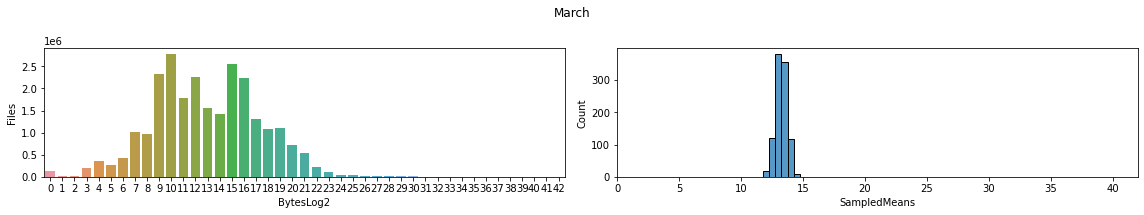

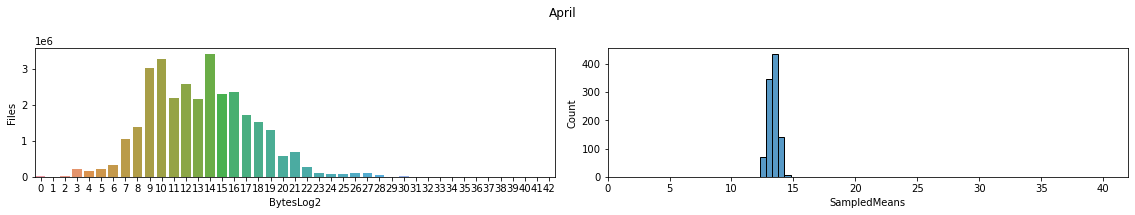

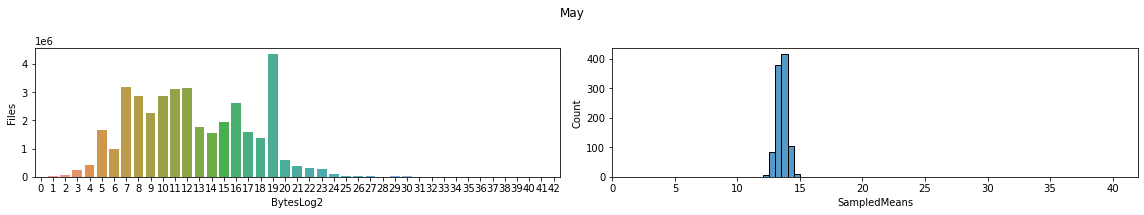

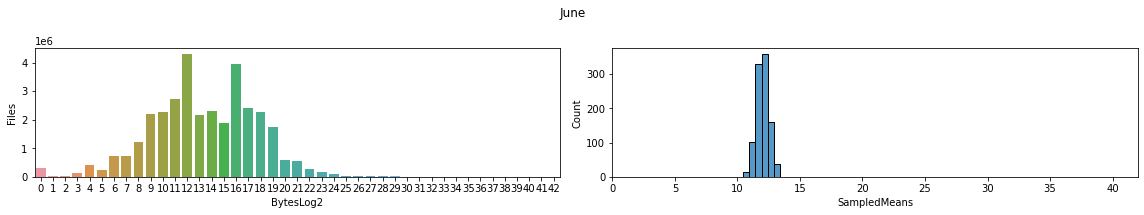

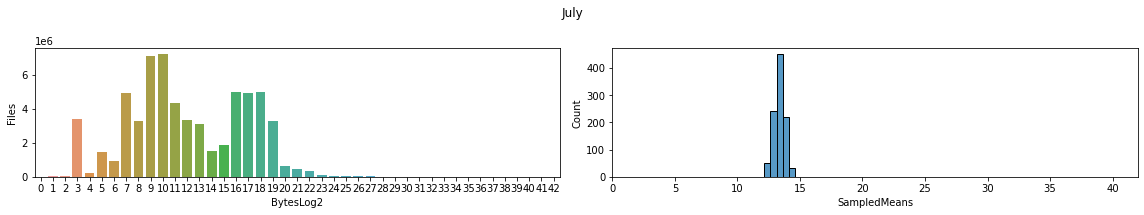

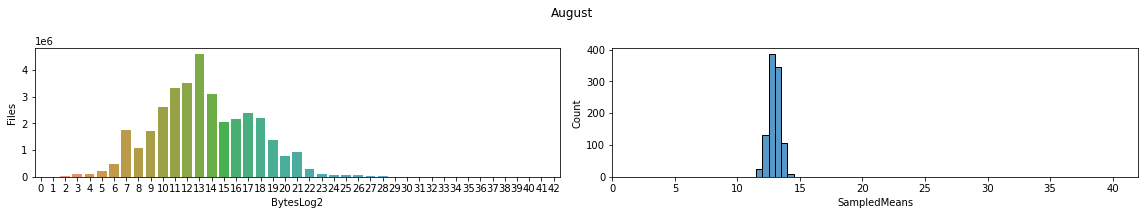

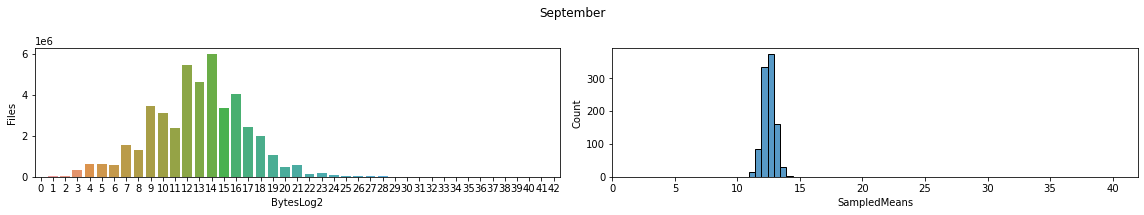

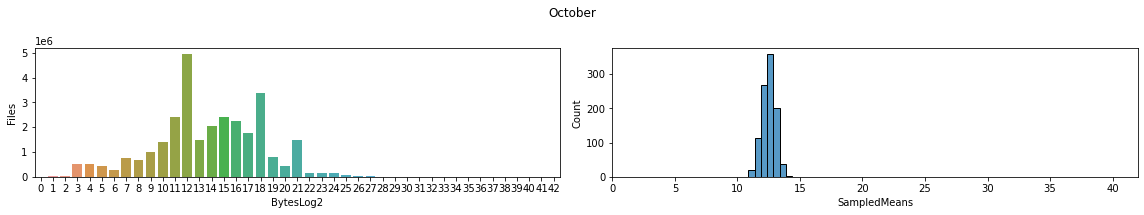

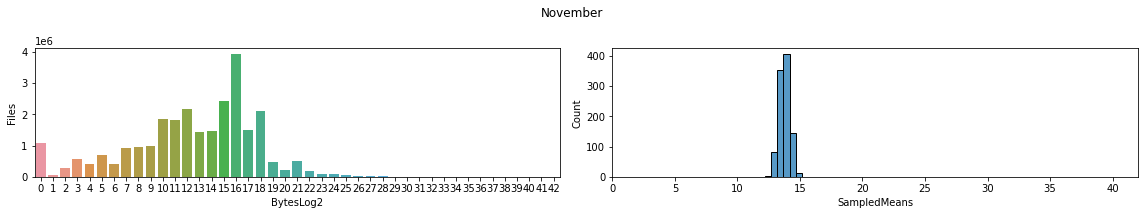

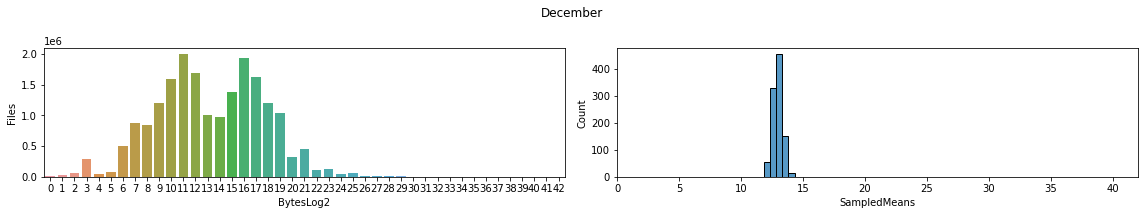

In [19]:
monthly_bytes_sum = aggregate_filesize_data(filesizes, ['Month','BytesLog2'], ['Files', 'SpaceUsage'], 'sum')
bootstrapped_monthly_means = bootstrap_byteslog2_mean(monthly_bytes_sum, 'Month', 'Files', n_means=1000)
bootstrapped_monthly_means_distribution = bootstrapped_monthly_means.drop('Mean', axis=1).explode('SampledMeans').reset_index()
bootstrapped_monthly_means_distribution.head()

for (month, real_data), (month_sampled, bootstrapped_data) in zip(monthly_bytes_sum.groupby('Month'), bootstrapped_monthly_means_distribution.groupby('Month')):
    figure, (ax1, ax2) = plt.subplots(1,2,figsize=(16,3))
    figure.suptitle(month)
    sb.barplot(x='BytesLog2', y='Files', data=real_data, ci=None, ax=ax1)
    sb.histplot(x='SampledMeans', binwidth=0.5, data=bootstrapped_data, ax=ax2)
    plt.xlim(left=min(yearly_bytes_sum['BytesLog2']), right=max(yearly_bytes_sum['BytesLog2']))
    plt.tight_layout()
    plt.savefig('file-distributions-%s_python.svg' % month)

## Fitting functions to data

In [22]:
yearly_cumsum = yearly_sum.copy()
yearly_cumsum.loc[:,['Files','SpaceUsage']] = yearly_cumsum[['Files','SpaceUsage']].cumsum()
yearly_cumsum.head()

,Year,Files,SpaceUsage
0,2010,5590287,2260716407068
1,2011,18787325,9261448518531
2,2012,35887225,24737023889111
3,2013,50642376,40182399191878
4,2014,76971697,82712763516200


<AxesSubplot:xlabel='Year', ylabel='SpaceUsage'>

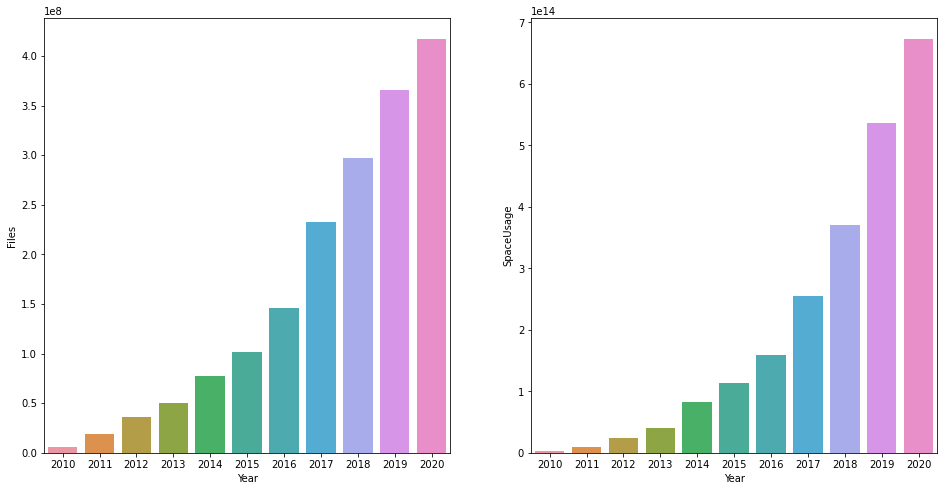

In [25]:
fig, ((ax1, ax2))=plt.subplots(ncols=2, figsize=(16,8))
sb.barplot(x='Year', y='Files', data=yearly_cumsum, ci=None, ax=ax1)
sb.barplot(x='Year', y='SpaceUsage', data=yearly_cumsum, ci=None, ax=ax2)

[DataFrame.reset_index](https://pandas.pydata.org/pandas-docs/version/0.17/generated/pandas.DataFrame.reset_index.html)

<AxesSubplot:xlabel='Year', ylabel='Files'>

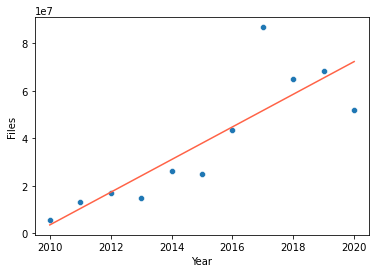

In [154]:
filesizes_yearly_sum = filesizes_yearly[['Year','Files']].groupby('Year').sum().reset_index()
sb.scatterplot(x='Year', y='Files', data=filesizes_yearly_sum)

from sklearn import linear_model
model = linear_model.LinearRegression()
model.fit(filesizes_sum[['Year']],filesizes_sum['Files'])
fitted_files = model.predict(filesizes_sum[['Year']])
sb.lineplot(x=filesizes_sum['Year'], y=fitted_files, color='tomato')

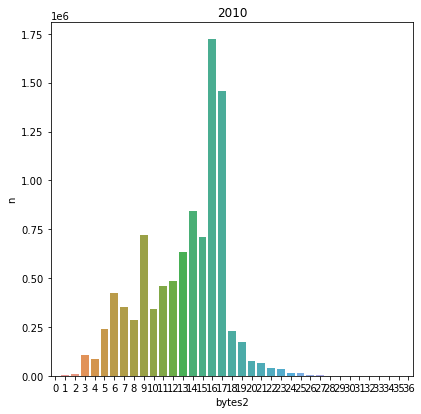

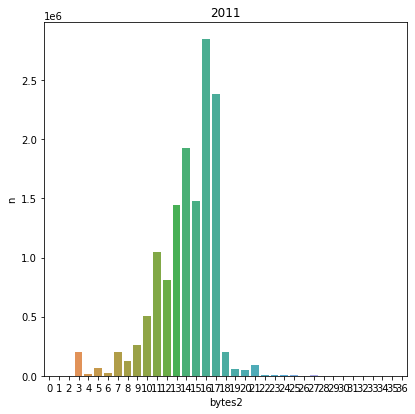

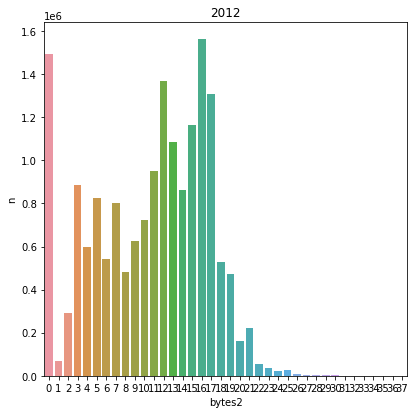

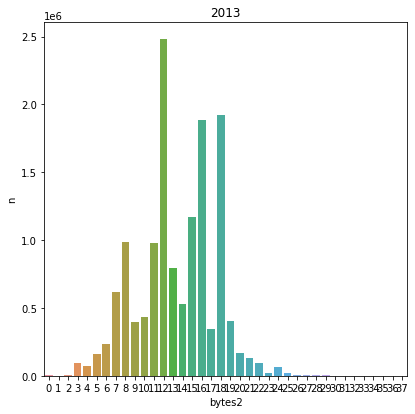

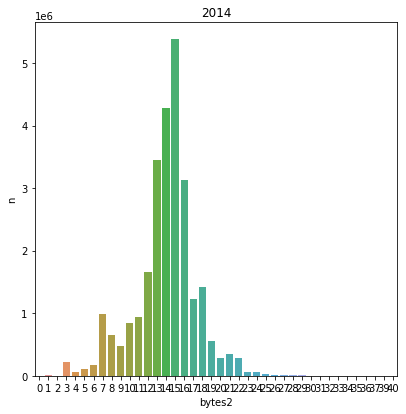

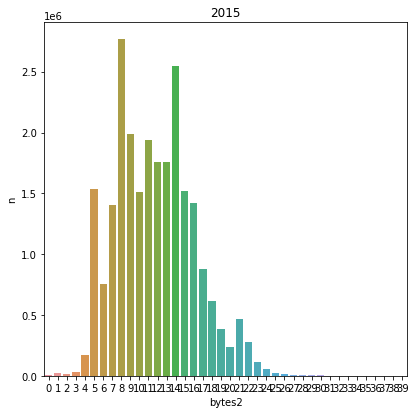

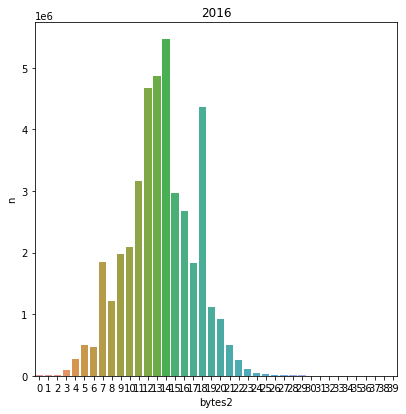

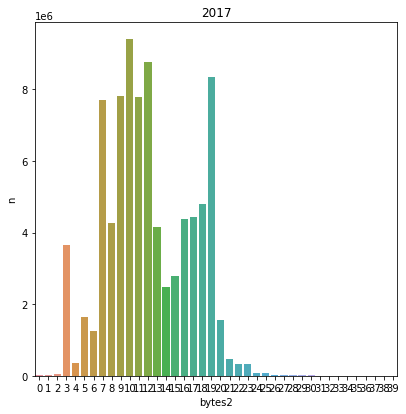

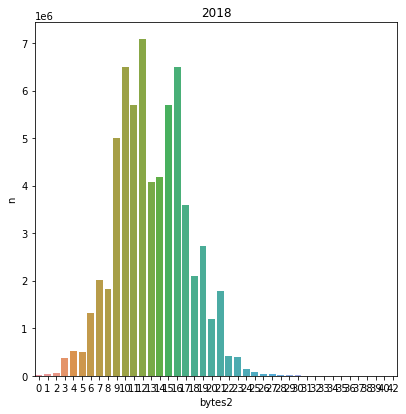

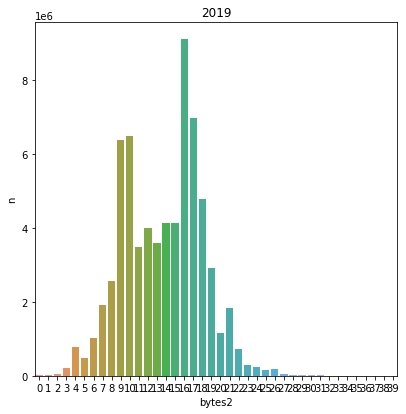

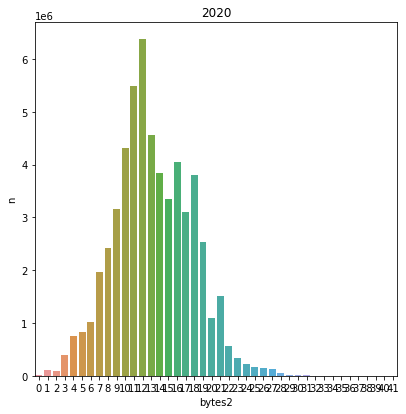

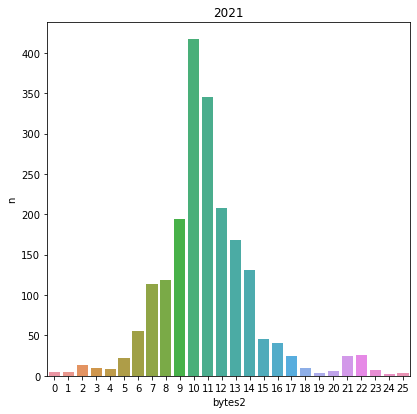

In [21]:
for year, yearly_data in filesizes_yearly.groupby('year'):
    filesizes_plot, filesizes_plot_ax = plt.subplots(figsize=(6.5, 6.5))
    sb.barplot(x='bytes2', y='n', data=yearly_data)
    plt.title(year)

In [22]:
filesizes_2020 = filesizes_yearly.loc[filesizes_yearly['year'] == 2020,:]

In [23]:
bins = filesizes_2020['bytes2'].astype('category')
bins

392     0
393     1
394     2
395     3
396     4
397     5
398     6
399     7
400     8
401     9
402    10
403    11
404    12
405    13
406    14
407    15
408    16
409    17
410    18
411    19
412    20
413    21
414    22
415    23
416    24
417    25
418    26
419    27
420    28
421    29
422    30
423    31
424    32
425    33
426    34
427    35
428    36
429    37
430    38
431    39
432    40
433    41
Name: bytes2, dtype: category
Categories (42, int64): [0, 1, 2, 3, ..., 38, 39, 40, 41]

In [24]:
def get_bootstrapped_mean(year):
    df = filesizes_yearly.loc[filesizes_yearly['year'] == year,:]
    dataset = df[['bytes2']].sample(100, replace=True, weights=df['n'])
    return dataset.mean()

get_bootstrapped_mean(2020)

bytes2    12.82
dtype: float64

In [10]:
from numpy.random import choice

def get_bootstrapped_mean2(year, n_means=10000):
    df = filesizes_yearly.loc[filesizes_yearly['year'] == year,:]
    bytes2 = df['bytes2']
    n = df['n']/df['n'].sum()
    means = np.zeros(n_means, dtype=np.float64)
    for i in range(n_means):
        means[i] = np.mean(choice(bytes2, 100, replace=True, p=n))
    return means

In [26]:
def get_bootstrapped_mean3(year, n_means=10000):
    df = filesizes_yearly.loc[filesizes_yearly['year'] == year,:]
    bytes2 = df[['bytes2']]
    n = df['n']
    means = np.zeros(n_means, dtype=np.float64)
    for i in range(n_means):
        means[i] = bytes2.sample(100, replace=True, weights=n).mean()
    return means

In [ ]:
%%timeit
n_means = 10000
means = np.zeros(n_means, dtype=np.float64)
for i in range(n_means):
    means[i] = get_bootstrapped_mean(2020)

In [ ]:
%%timeit
get_bootstrapped_mean2(2020)

In [ ]:
%%timeit
get_bootstrapped_mean3(2020)

In [ ]:
get_bootstrapped_mean3(2020)

In [ ]:
plt.hist(p, bins=bins)

In [27]:
years = filesizes_yearly['year'].unique()
bytes2 = filesizes_yearly['bytes2'].unique()

In [34]:
filesizes_sampled = pd.DataFrame({'year':years})
filesizes_sampled['sampled_means'] = filesizes_sampled.loc[:,'year'].apply(get_bootstrapped_mean2)

In [35]:
filesizes_sampled = filesizes_sampled.explode('sampled_means')
filesizes_sampled['sampled_means'] = filesizes_sampled['sampled_means'].astype(np.float64)

In [36]:
filesizes_sampled.dtypes

year               int64
sampled_means    float64
dtype: object

In [37]:
filesizes_sampled.groupby('year')['sampled_means'].mean()

year
2010    13.197945
2011    14.133348
2012    10.671955
2013    13.412672
2014    14.026149
2015    11.728573
2016    13.406113
2017    12.136109
2018    13.132024
2019    13.730133
2020    13.236934
2021    10.956056
Name: sampled_means, dtype: float64

In [ ]:
for year in years:
    
    sample_data = filesizes_sampled.loc[filesizes_sampled['year'] == year, ['sampled_means']]
    bytes_data = filesizes_yearly.loc[filesizes_yearly['year'] == year, ['bytes2','n']]
    
    filesizes_plot, (filesizes_plot_ax1, filesizes_plot_ax2) = plt.subplots(nrows=2,figsize=(6.5, 6.5))
    sb.barplot(x='bytes2', y='n', data=bytes_data, ax=filesizes_plot_ax1)
    filesizes_plot_ax1.set_xticks(ticks=bytes2[::4])
    filesizes_plot_ax1.set_xlim(left=bytes2[0], right=bytes2[-1])
    sb.histplot(x='sampled_means', bins=10, data=sample_data, ax=filesizes_plot_ax2)
    filesizes_plot_ax2.set_xticks(ticks=bytes2[::4])
    filesizes_plot_ax2.set_xlim(left=bytes2[0], right=bytes2[-1])
    plt.title(year)
    plt.tight_layout()

In [ ]:
import numpy as np

In [ ]:
from itertools import product

In [ ]:
samples = pd.DataFrame([ (x,y) for x,y in product(range(10000), years) ], columns=('sample', 'year'))

In [ ]:
samples['mean_filesize'] = samples['year'].apply(get_bootstrapped_mean)

In [ ]:
import numpy as np

In [ ]:
samples['mean_filesize'] = np.vectorize(get_bootstrapped_mean)(samples['year'])

In [ ]:
for year in years:
    
    sample_data = samples.loc[samples['year'] == year, ['mean']]
    bytes_data = filesizes_yearly.loc[filesizes_yearly['year'] == year, ['bytes2','n']]
    
    filesizes_plot, (filesizes_plot_ax1, filesizes_plot_ax2) = plt.subplots(nrows=2,figsize=(6.5, 6.5))
    sb.barplot(x='bytes2', y='n', data=bytes_data, ax=filesizes_plot_ax1)
    filesizes_plot_ax1.set_xticks(ticks=bytes2[::4])
    filesizes_plot_ax1.set_xlim(left=bytes2[0], right=bytes2[-1])
    sb.histplot(x='mean_filesize', bins=10, data=sample_data, ax=filesizes_plot_ax2)
    filesizes_plot_ax2.set_xticks(ticks=bytes2[::4])
    filesizes_plot_ax2.set_xlim(left=bytes2[0], right=bytes2[-1])
    plt.title(year)
    plt.tight_layout()

In [ ]:
samples['mean']

In [ ]:
sb.barplot(x='bytes2', y='mean_filesize', data=filesizes_sampled2020)